In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from qr_methods import generateGaussData
from conditionalconformal import CondConf

%load_ext autoreload
%autoreload 2

In [4]:
### Evaluate coverage and quantile estimate size of the randomized method of 
### Gibbs, Cherian, and Candes (2025) conditional on the cutoff U
def oneUTrial(nTrain, nTest, d, alpha, Ugrid, sigma_sq_eps = 1):

    XTrain, YTrain, XTest, YTest, _ = generateGaussData(nTrain, nTest, d)


    XTrainInt = np.column_stack((np.ones(nTrain),XTrain))
    XTestInt = np.column_stack((np.ones(nTest),XTest))
        
    scoreFn = lambda x, y : y if isinstance(y, np.ndarray) else np.array([y])
    phiFn = lambda x : x if isinstance(x, np.ndarray) else np.array([x])
    condCovProgram = CondConf(scoreFn, phiFn)
    condCovProgram.setup_problem(XTrainInt,YTrain)
    
    coverages = [0]*(nTest*len(Ugrid))
    cutoffs = [0]*(nTest*len(Ugrid))
    Us = [0]*(nTest*len(Ugrid))

    count = 0
    for i in range(nTest):
        for U in Ugrid:
            quantileEst = condCovProgram.predict(1-alpha, XTestInt[i,:].reshape(1,d+1),
                                            lambda a, b : a, exact=True, threshold = U)[0]
            Us[count] = U
            cutoffs[count] = quantileEst
            coverages[count] = (YTest[i] <= quantileEst)
            count += 1

    res = pd.DataFrame({'Coverage' : coverages, 'Cutoff': cutoffs, 'U': Us})
    return res


nTrials = 2000
nTrain = 200
nTest = 1
d = 40
alpha = 0.1
Ugrid = np.arange(-alpha+0.05,1-alpha+0.05,0.1)

res = pd.DataFrame()
for i in tqdm(range(nTrials)):
    resOneTrial = oneUTrial(nTrain, nTest, d, alpha, Ugrid)
    res = pd.concat([res,resOneTrial])

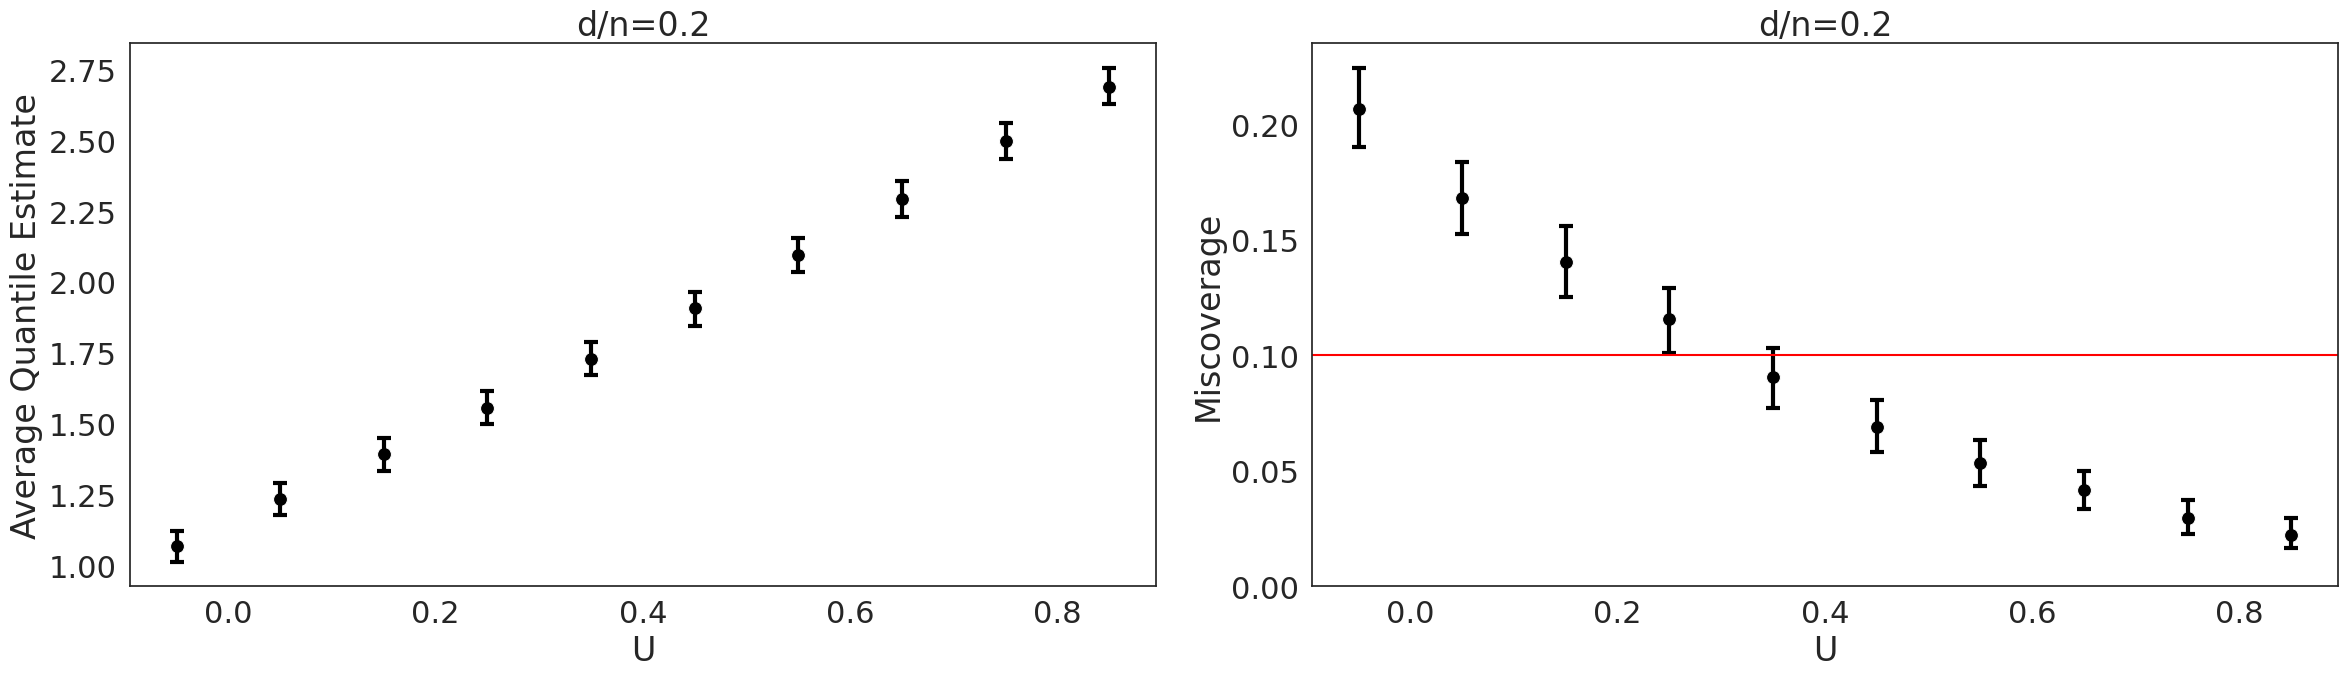

In [7]:
### Plot results
sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

res['Miscoverage'] = 1-res['Coverage']
res['U_rounded'] = [round(U,2) for U in res['U']]

ax1 = fig.add_subplot(1,2,1)
f1 = sns.lineplot(
    data=res,
    x='U',
    y='Cutoff',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    color = 'black',
    ax = ax1,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)
ax1.set_ylabel('Average Quantile Estimate')
ax1.set_xlabel('U')
ax1.set_title('d/n=0.2')


ax2 = fig.add_subplot(1,2,2)
f2 = sns.lineplot(
    data=res,
    x='U',
    y='Miscoverage',
    marker='o',
    linestyle='',
    err_style='bars',
    errorbar=('ci', 95),
    markersize=10,
    color = 'black',
    ax = ax2,
    err_kws={"capsize": 5, "elinewidth": 3, "capthick": 3}
)
ax2.set_ylabel('Miscoverage')
ax2.set_xlabel('U')
ax2.set_ylim(0,0.235)
ax2.set_title(r'd/n=0.2')


f2.axhline(alpha,color='red')

plt.tight_layout()
plt.savefig('figures/UConditionalCoverage.pdf')